# Car Recognition with Deep Learning

This tutorial shows how Neural Networks are used to recognize cars on images vs. images with no cars on them (binary classification).

The data set used is the [UIUC Image Database for Car Detection](http://cogcomp.cs.illinois.edu/Data/Car/) containing:
* 1050 training images (550 car and 500 non-car images)
* 170 test images, containing 200 cars at roughly the same scale as in the training images 
(we do not use the multi-scale test images, containing 139 cars at various scales, here)

This tutorial contains:
* Image Loading and Preprocessing
* Standardization of Data
* Fully Connected Neural Networks
* Convolutional Neural Networks
* Batch Normalization
* ReLU Activation
* Dropout
* Data Augmentation

You can execute the following code blocks by pressing SHIFT+Enter consecutively.

In [1]:
import os

# if you want to use the GPU
#device = 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np

from PIL import Image
from theano import config
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization


Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


## Load the Images from Training Set

In [2]:
path = 'data/CarData/TrainImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 1050 files


In [3]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        images.append(np.array(img))

pos-315.pgm


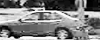

In [4]:
i=5
print image_names[i]
Image.fromarray(images[i])

In [5]:
type(images[i])

numpy.ndarray

In [6]:
images[i].shape   # height x width

(40, 100)

Note: Color RGB images have an additional dimension of depth 3, e.g. (40, 100, 3)

## Make 1 big array of list of images

In [7]:
# a list of many 40x100 images is made into 1 big array
# config.floatX is from Theano configration to enforce float32 precision (needed for GPU computation)
img_array = np.array(images, dtype=config.floatX)
img_array.shape

(1050, 40, 100)

## Create the Groundtruth based on filenames:

In this data set, images with cars start with "pos-" and images with no cars start with "neg-". We create a numeric list here containing 1 for car images and 0 for non-car images.

In [8]:
classes = []
for name in image_names:
    if name.startswith('neg'):
        classes.append(0)
    else:
        classes.append(1)

In [9]:
# look at the first 25 classes
classes[0:25]

[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]

In [10]:
print "Groundtruth Statistics:"

for v in set(classes):
    print "Class", v, ":", classes.count(v)

Groundtruth Statistics:
Class 0 : 500
Class 1 : 550


In [11]:
baseline = 550 * 1.0 / len(classes)
baseline

0.5238095238095238

The baseline is 52.3%, i.e. a 'dumb' classifier can assign all predictions to the majority class achieving this accurcay. We aim at building a classifier that performs better than that.

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

Here we use <b>Zero-mean Unit-variance standardization</b> (flat, i.e. one mean and std.dev. for the whole image is computed over all pixels; in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [12]:
mean = img_array.mean()
stddev = img_array.std()
print mean, stddev

129.582 74.2767


In [13]:
img_array = (img_array - mean) / stddev
print img_array.mean(), img_array.std()

1.27098e-07 1.0


In [14]:
img_array.min(), img_array.max()

(-1.7445904, 1.6885173)

# Creating NN Models in Keras

## 1) Fully Connected NN

For a fully connected neural network, the x and y axis of an image do not play a role at all. All pixels are considered as a completely individual input to the neural network. Therefore the 2D image arrays have to be flattened to a vector.

In [15]:
#  flatten images to vectors
images_flat = img_array.reshape(img_array.shape[0],-1)
print images_flat.shape

(1050, 4000)


In [16]:
# find out input shape for NN, which is just a long vector (40x100 = 4000)
input_shape = images_flat.shape[1]
print input_shape

4000


### Creating a Model

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

Here we create a sequential model with 2 fully connected (a.k.a. 'dense') layers containing 256 units each.

In [17]:
# simple Fully-connected network

model = Sequential()

model.add(Dense(256, input_dim=input_shape))

model.add(Dense(256))

model.add(Dense(1,activation='sigmoid'))



In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 256)           1024256     dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 256)           65792       dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             257         dense_2[0][0]                    
Total params: 1090305
____________________________________________________________________________________________________


### Defining Loss Function and Optimizer Strategy: Gradient Descent

In [19]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Compiling the model
# This creates the whole model structure in memory. 
# If you use GPU computation, here GPU compatible structures and code is generated.
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

### Training the model on the input dataset

In [20]:
epochs = 15
model.fit(images_flat, classes, batch_size=32, nb_epoch=epochs) #, validation_data=validation_data) 

Epoch 1/15
1050/1050 [==============================] - 0s - loss: 0.5297 - acc: 0.7819     
Epoch 2/15
1050/1050 [==============================] - 0s - loss: 0.3020 - acc: 0.8629     
Epoch 3/15
1050/1050 [==============================] - 0s - loss: 0.2333 - acc: 0.8962     
Epoch 4/15
1050/1050 [==============================] - 0s - loss: 0.1989 - acc: 0.9229     
Epoch 5/15
1050/1050 [==============================] - 0s - loss: 0.1526 - acc: 0.9467     
Epoch 6/15
1050/1050 [==============================] - 0s - loss: 0.1229 - acc: 0.9638     
Epoch 7/15
1050/1050 [==============================] - 0s - loss: 0.0995 - acc: 0.9790     
Epoch 8/15
1050/1050 [==============================] - 0s - loss: 0.0823 - acc: 0.9838     
Epoch 9/15
1050/1050 [==============================] - 0s - loss: 0.0741 - acc: 0.9867     
Epoch 10/15
1050/1050 [==============================] - 0s - loss: 0.0622 - acc: 0.9895     
Epoch 11/15
1050/1050 [==============================] - 0s - loss: 0

In [21]:
# verify Accuracy on Train set
predictions = model.predict_classes(images_flat)
accuracy_score(classes, predictions)

 992/1050 [===========================>..] - ETA: 0s

1.0

### 100% Accuracy - perfect, no?

This is the accuracy on the training set. A (large, especially fully connected network with sufficient number of units) can easily learn the entire training set (especially a small one like here).

This very likely leads to <b>overfitting</b>. That's why we test on an independent test set.


# Testing with Test Data Set

In [22]:
path = 'data/CarData/TestImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 170 files


In [23]:
from image_preprocessing import resize_and_crop

test_images = []

for filename in files:
    with Image.open(filename) as img:
        img_resized = resize_and_crop(img,target_width=100,target_height=40)
        test_images.append(np.array(img_resized))
        #print img.size, img_resized.size

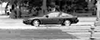

In [24]:
i=3
Image.fromarray(test_images[i])

In [25]:
# make 1 big array again from list
test_images = np.array(test_images)

### Standardize Test Set

The test data has to be standardized <b>in the same way</b> as the training data for compatibility with the model! That means, we take the mean and standard deviation of the <i>training data</i> to transform also the test data.

In [26]:
# NO! we take the same mean and stddev from the training data above!
#mean = test_images.mean()
#stddev = test_images.std()
#print mean, stddev

In [27]:
test_images.mean(), test_images.std()

(121.71342647058823, 72.05232875177191)

In [28]:
test_images = (test_images - mean) / stddev

### Flatten Images for Full model

In [29]:
test_images_flat = test_images.reshape(test_images.shape[0],-1)
print test_images_flat.shape

(170, 4000)


### Make Predictions

In [30]:
test_pred = model.predict_classes(test_images_flat)
# show 30 first predictions
test_pred[0:30,0]

 32/170 [====>.........................] - ETA: 0s

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [31]:
# Groundtruth:
# this TEST SET contains ONLY CARS on images! 
# Thus all the test classes are 1
test_classes = [1] * len(files)

In [32]:
# let's count the number of ones ...
test_pred.sum()

82

In [33]:
acc = accuracy_score(test_classes, test_pred)
acc

0.4823529411764706

In [34]:
70.0/170

0.4117647058823529

Accuracy on the Test Set is only 41.17%.

# Convolutional Neural Network

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which groups neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

### Input

Our input to the CNN is the standardized version of the original image array.

#### Adding the channel

For CNNs, we need to add a dimension for the color channel to the data. RGB images typically have an 3rd dimension with the color. 
<b>For greyscale images we need to add an extra dimension for compatibility with the CNN implementation.</b>

In Theano, traditionally the color channel was the <b>first</b> dimension in the image shape. 
In Tensorflow, the color channel is the <b>last</b> dimension in the image shape. 

This can be configured now in ~/.keras/keras.json: "image_dim_ordering": "th" or "tf" with "tf" (Tensorflow) being the default image ordering even though you use Theano. Depending on this, use one of the code lines below.

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [35]:
n_channels = 1 # for grey-scale, 3 for RGB, but usually already present in the data

if keras.backend.image_dim_ordering() == 'th':
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_img = img_array.reshape(img_array.shape[0], n_channels, img_array.shape[1], img_array.shape[2])
    test_img = test_images.reshape(test_images.shape[0], n_channels, test_images.shape[1], test_images.shape[2])
else:
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_img = img_array.reshape(img_array.shape[0], img_array.shape[1], img_array.shape[2], n_channels)
    test_img = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], n_channels)

In [36]:
img_array.shape

(1050, 40, 100)

In [37]:
train_img.shape

(1050, 1, 40, 100)

In [38]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
    
input_shape = train_img.shape[1:]  
input_shape

(1, 40, 100)

## Create the CNN model

In [39]:
model = Sequential()

n_filters = 16
# this applies 32 convolution filters of size 3x3 each.

model.add(Convolution2D(n_filters, 5, 5, border_mode='valid', input_shape=input_shape))
# input shape: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 

model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3)) 

# B)
model.add(Convolution2D(n_filters, 3, 3))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten()) # Note: Keras does automatic shape inference.

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))

If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

In [40]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 36, 96)    416         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 16, 36, 96)    192         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 36, 96)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 18, 48)    0           activation_1[0][0]               
___________________________________________________________________________________________

## Training the CNN

In [41]:
# Compiling the model
loss = 'binary_crossentropy' 
optimizer = 'sgd' 
#optimizer = SGD(lr=0.001)  # possibility to adapt the learn rate

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# TRAINING the model
epochs = 15
history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs)

### Training with Validation Data

We split off 10 % of the training data and use it as independend validation set to verify how good we are
on an independent data (not used for training) in each epoch

In [108]:
history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs, validation_split=0.1) 

Train on 945 samples, validate on 105 samples
Epoch 1/15
945/945 [==============================] - 5s - loss: 0.0698 - acc: 0.9788 - val_loss: 0.0683 - val_acc: 0.9810
Epoch 2/15
945/945 [==============================] - 5s - loss: 0.0489 - acc: 0.9841 - val_loss: 0.0451 - val_acc: 0.9905
Epoch 3/15
945/945 [==============================] - 5s - loss: 0.0314 - acc: 0.9905 - val_loss: 0.0319 - val_acc: 0.9905
Epoch 4/15
945/945 [==============================] - 5s - loss: 0.0284 - acc: 0.9905 - val_loss: 0.0340 - val_acc: 0.9905
Epoch 5/15
945/945 [==============================] - 5s - loss: 0.0227 - acc: 0.9947 - val_loss: 0.0282 - val_acc: 0.9905
Epoch 6/15
945/945 [==============================] - 5s - loss: 0.0173 - acc: 0.9947 - val_loss: 0.0324 - val_acc: 0.9905
Epoch 7/15
945/945 [==============================] - 5s - loss: 0.0107 - acc: 0.9989 - val_loss: 0.0236 - val_acc: 0.9905
Epoch 8/15
945/945 [==============================] - 5s - loss: 0.0083 - acc: 0.9989 - val_l

The results on the split-off validation data are quite high (usually similar, but not as high as on the training data).

### Using Test Set as Validation Set

<b>Note: This usually is not recommended as during experimentation you will overfit also to the test data.</b>

We show it here only for demonstration purposes to see how (bad) the validation accuracy is on our independet test data. The recommended way is to have a separate training, validation and test set (i.e. 3 splits or separate data set 

In [109]:
# Show Result on Test Data while training 
# we use test data as validation data to see direct results (usually NOT RECOMMENDED due to overfitting to the problem!)
validation_data = (test_img, test_classes)

history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs, validation_data=validation_data) 

Train on 1050 samples, validate on 170 samples
Epoch 1/15
1050/1050 [==============================] - 6s - loss: 0.0058 - acc: 0.9981 - val_loss: 6.4739 - val_acc: 0.1118
Epoch 2/15
1050/1050 [==============================] - 6s - loss: 0.0071 - acc: 0.9981 - val_loss: 6.2653 - val_acc: 0.1176
Epoch 3/15
1050/1050 [==============================] - 6s - loss: 0.0044 - acc: 1.0000 - val_loss: 6.3239 - val_acc: 0.1176
Epoch 4/15
1050/1050 [==============================] - 6s - loss: 0.0040 - acc: 1.0000 - val_loss: 7.3631 - val_acc: 0.0941
Epoch 5/15
1050/1050 [==============================] - 6s - loss: 0.0037 - acc: 1.0000 - val_loss: 6.8158 - val_acc: 0.1118
Epoch 6/15
1050/1050 [==============================] - 6s - loss: 0.0047 - acc: 0.9990 - val_loss: 7.2102 - val_acc: 0.1059
Epoch 7/15
1050/1050 [==============================] - 6s - loss: 0.0039 - acc: 0.9990 - val_loss: 7.0418 - val_acc: 0.1176
Epoch 8/15
1050/1050 [==============================] - 6s - loss: 0.0036 - ac

### Verifying Accuracy on Test Set

In [110]:
test_pred = model.predict_classes(test_img)
# show 35 first predictions
test_pred[0:35,0].tolist()

170/170 [==============================] - 0s     


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [107]:
predictions = model.predict_classes(test_img)
accuracy_score(test_classes, predictions)

170/170 [==============================] - 0s     


0.58823529411764708

#### Conclusion: We are completely overfitting!
While we achieve nearly 100% on the Training Set, the generalization to the Test Set is really bad, with an Accuracy of about only 10%.

# Data Augmentation

Increase the training set by adding more images: Rotate, shift, flip and scale the original images to generate additional examples that will help the Neural Network to generalize better.

In [119]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True)

In [120]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(train_img)

In [121]:
# ImageDataGenerator needs the classes as Numpy array instead of normal list
classes_array = np.array(classes)

In [122]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(train_img, classes_array, batch_size=32),
                    samples_per_epoch=len(train_img), nb_epoch=epochs,
                    validation_data=validation_data) 

Epoch 1/15
1050/1050 [==============================] - 6s - loss: 0.1626 - acc: 0.9400 - val_loss: 1.4034 - val_acc: 0.4118
Epoch 2/15
1050/1050 [==============================] - 6s - loss: 0.1518 - acc: 0.9352 - val_loss: 1.2689 - val_acc: 0.4588
Epoch 3/15
1050/1050 [==============================] - 6s - loss: 0.1627 - acc: 0.9333 - val_loss: 1.4350 - val_acc: 0.4059
Epoch 4/15
1050/1050 [==============================] - 6s - loss: 0.1566 - acc: 0.9438 - val_loss: 1.1026 - val_acc: 0.5000
Epoch 5/15
1050/1050 [==============================] - 6s - loss: 0.1669 - acc: 0.9343 - val_loss: 1.1472 - val_acc: 0.4824
Epoch 6/15
1050/1050 [==============================] - 6s - loss: 0.1508 - acc: 0.9419 - val_loss: 1.0082 - val_acc: 0.5235
Epoch 7/15
1050/1050 [==============================] - 6s - loss: 0.1944 - acc: 0.9248 - val_loss: 1.1814 - val_acc: 0.4294
Epoch 8/15
1050/1050 [==============================] - 6s - loss: 0.1447 - acc: 0.9400 - val_loss: 1.4667 - val_acc: 0.4059


### Verifying Accuracy on Test Set (with Data Augmentation)

In [117]:
test_pred = model.predict_classes(test_img)
# show 35 first predictions
test_pred[0:35,0].tolist()

170/170 [==============================] - 0s     


[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]

In [118]:
predictions = model.predict_classes(test_img)
accuracy_score(test_classes, predictions)

170/170 [==============================] - 0s     


0.44117647058823528